## 지난주 개념 복습!
아래 마크다운을 풀고, 지난주 예습과제를 통해 공부한 Vision Transformer의 특징과 다른 모델들과의 차이점을 간략히 설명해주세요.

- Vision Transformer는 vision task 에 nlp transformer의 self-attention을 결한 구조로, 새로운 접근 방식을 제시하였다.
- Vision Transformer는 이미지를 일정 크기의 패치로 자르고 각 패치를 NLP의 토큰처럼 처리한다.
- CNN 기반이 지역적 Convolution 필터를 사용했던 것과 달리, Vision Transformer는 전역적 attention을 기반으로 한다.
- 데이터가 대규모일 때 적합한 방식이다.

## 파이토치로 구현한 Vision Transformer
이번 복습과제에서는 카사바 잎 질병 데이터셋으로 vision transformer를 학습시키겠습니다.
- 첨부된 드라이브에서 필요한 파일들을 다운받을 수 있습니다.

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7
!pip install timm
!pip install torch_xla

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     69      0 --:--:-- --:--:-- --:--:--    69
  File "/content/pytorch-xla-env-setup.py", line 1
    404: Not Found
    ^^^
SyntaxError: illegal target for annotation
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00


### 데이터 불러오기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# #.zip 파일 unzip
# #본인 드라이브의 경로에 맞게 수정해주세요!
# !unzip /content/drive/MyDrive/dataset/EURON_week9/train_images.zip -d  /content/drive/MyDrive/dataset/EURON_week9/train_images

In [6]:
# #본인 드라이브의 경로에 맞게 수정해주세요!
# !unzip /content/drive/MyDrive/dataset/EURON_week9/jx_vit_base_p16_224-80ecf9dd.pth.zip -d /content/drive/MyDrive/dataset/EURON_week9/

In [7]:
#파일 경로
DATA_PATH = "/content/drive/MyDrive/dataset/EURON_week9"
TRAIN_PATH = "/content/drive/MyDrive/dataset/EURON_week9/train_images"
TEST_PATH = "/content/drive/MyDrive/dataset/EURON_week9/test.jpg"
MODEL_PATH = (
    "/content/drive/MyDrive/dataset/EURON_week9/jx_vit_base_p16_224-80ecf9dd.pth"
)

### 라이브러리

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

In [9]:
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [10]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

### 파라미터

In [11]:
IMG_SIZE = 224  #ViT에 적합한 이미지 크기로 설정해주세요.
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 1  #모델 학습을 위해서는 더 많은 에포크가 필요하지만, 파일 크기가 큰 관계로 이번 과제에서는 전 과정을 한 번만 수행하겠습니다.

In [12]:
# pandas로 csv 파일을 읽은 뒤, 첫 5행을 출력하세요.
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


<Axes: xlabel='label'>

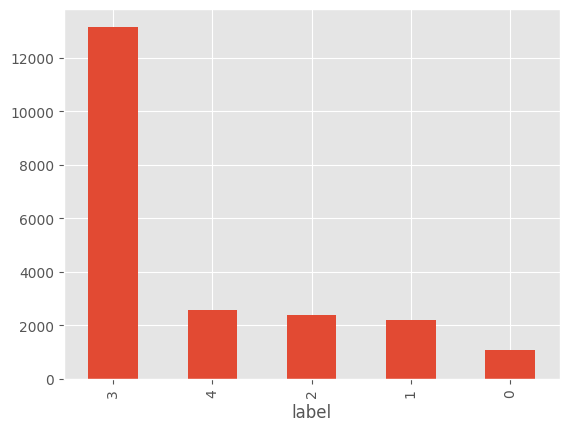

In [14]:
df.label.value_counts().plot(kind="bar")

In [15]:
# train과 test를 9:1로 나눠주세요.
# random_state은 자유롭게 지정 가능합니다.
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.label.values
)

In [16]:
class CassavaDataset(torch.utils.data.Dataset):

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [17]:
#데이터 증강
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [18]:
#사용 가능한 ViT 모델 목록
##우리는 이중 vit_base_patch16_224를 사용합니다!
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32

### 모델 설계
- 클래스 ViTBase16의 각 줄을 설명하는 주석을 달아주세요. (최소 15개)

In [19]:
# 이 셀 안의 코드에 대해서 주석을 달아주세요.
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        # 사전학습 ViT 로드
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)  # pretrained: 사전 학습 가중치 사용여부
        if pretrained:  # pretrained=True 면 외부 저장 모델 가중치 불러와 초기화
            self.model.load_state_dict(torch.load(MODEL_PATH))

        # 새로운 데이터셋의 클래스 수에 맞게 head(마지막 분류층) 수 조정
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    # 순전파 정의
    def forward(self, x):
        x = self.model(x)
        return x

    # 1 에포크 학습 과정 정의
    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        epoch_loss = 0.0  # 손실 초기화
        epoch_accuracy = 0.0  # 정확도 초기화

        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            if device.type == "cuda":  # GPU 환경일 경우
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":  # TPU 환경일 경우
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            optimizer.zero_grad()  # 기울기 초기화
            output = self.forward(data)  # 모델 예측
            loss = criterion(output, target)  # loss 계산
            loss.backward()  # 역전파
            accuracy = (output.argmax(dim=1) == target).float().mean()  # accuracy 계산

            epoch_loss += loss
            epoch_accuracy += accuracy

            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    # 1 에포크 검증 과정 정의
    def validate_one_epoch(self, valid_loader, criterion, device):
        valid_loss = 0.0
        valid_accuracy = 0.0

        self.model.eval()
        for data, target in valid_loader:
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():  # grad 계산 X
                output = self.model(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()

                valid_loss += loss
                valid_accuracy += accuracy

        # 평균 loss, 정확도 반환
        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [20]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.inf

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [21]:
model = ViTBase16(n_classes=5, pretrained=True)

In [24]:
def _run():
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()  #cross entropy loss로 설정.
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [25]:
# Training 시작
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()


# Run
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=1, start_method="fork")

INITIALIZING TRAINING ON 1 TPU CORES
Start Time: 2025-05-12 05:07:40.732935
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 0.0, ACCURACY: 0.0


Exception in thread Thread-9 (_loader_worker):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch_xla/distributed/parallel_loader.py", line 165, in _loader_worker
    _, data = next(data_iter)
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1480, in _next_data
    return self._process_data(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1505, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.11/dist-packages/torch/_utils.py", line 733, i


EPOCH 1 - VALIDATING...


Exception in thread Thread-11 (_loader_worker):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch_xla/distributed/parallel_loader.py", line 165, in _loader_worker
    _, data = next(data_iter)
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1480, in _next_data
    return self._process_data(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1505, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.11/dist-packages/torch/_utils.py", line 733, 

	[VALID] LOSS: 0.0, ACCURACY: 0.0

Execution time: 0:00:41.987405
Saving Model
